In [1]:
import numpy as np
from QAM_EncoderDecoder import * 
from scipy.io.wavfile import write, read
import matplotlib.pyplot as plt
import sounddevice as sd
import soundfile as sf
from IPython.display import Audio
from scipy import interpolate, signal
from ldpc_jossy.py import ldpc
from util import *

%matplotlib inline



In [2]:
# constants

N = 2048
prefix_no = 256
fs = 44100

inputLenIndicator_len=32
inputGuard_len=8
N = 2048
rate = '1/2'
r = 0.5
z = 81 # new standard
len_protection = 'input_repeat_then_LDPC'
#len_protection = 'no'
repeat_times = 5

In [3]:
def random_symbols_from_binary(length, seed):
    """Returns a 'length'-long sequence of random constellation symbols"""

    rng = np.random.default_rng(seed)
    random_binary_sequence = rng.integers(low=0, high=2, size=2*length) # x2 as converting from binary to QPSK
    random_binary_values = np.split(random_binary_sequence, length)

    mapping = {
        '0 0':  1+1j,
        '0 1': -1+1j,
        '1 1': -1-1j,
        '1 0':  1-1j
    }

    random_symbols = np.array([mapping[str(r)[1:-1]] for r in random_binary_values])
    
    return random_symbols

In [4]:
def define_chirp(sec=1):
    """returns standard log chirp waveform and its time-reverse"""
    
    k = 50
    w1 = 100
    w2 = 10000
    
    t = np.linspace(0, sec, int(fs*sec))
    
    ch = np.sin(2*np.pi*sec*w1*(((w2/w1)**(t/sec)-1)/(np.log(w2/w1))))*(1-np.e**(-k*t))*(1-np.e**(k*(t-sec))) # analytical form
    
    ch /= 5 # scale so roughly same 'height' as OFDM blocks
    
    inv_ch = np.flip(ch)
    
    return ch, inv_ch


In [5]:
def encode_bitstr2symbols_via_LDPC(bits,inputLenIndicator_len=32, inputGuard_len=8,N=2048,rate='1/2',r=0.5,z=81,len_protection='input_repeat_then_LDPC',repeat_times=5,test=False):

    LDPC_encoded_bits=LDPC_encode(bits,inputLenIndicator_len=inputLenIndicator_len, inputGuard_len=inputGuard_len,N=N,rate=rate,r=r,z=z,len_protection=len_protection,repeat_times=repeat_times,test=test)
    bits=LDPC_encoded_bits

    
    symbols=[]
    for i in range(0,len(bits),2):
        bit1=bits[i]
        bit2=bits[i+1]
        a=1
        if bit1=="0":
            if bit2=="0":
                symbol=np.complex128(complex(1,1))
            else:
                symbol=np.complex128(complex(-1,1))
        else:
            if bit2=="0":
                symbol=np.complex128(complex(1,-1))
            else:
                symbol=np.complex128(complex(-1,-1))
        symbols.append(symbol)

    return symbols

In [6]:
def create_single_OFDM_frame(seed):
    """Uses pseudo-random symbols to generate single known OFDM frame"""
    
    rand_symbols = random_symbols_from_binary(N//2-1, seed) # need 1023 symbols
    frame = np.zeros(N//2, dtype=complex)
    frame[1:] = rand_symbols
    frame = np.append(frame, np.append(0,np.conj(frame)[:0:-1]))
    frame = np.fft.ifft(frame)
    frame = np.real(frame)
    frame = np.append(frame[N-prefix_no:N], frame)
    
    return frame


In [7]:
def create_known_OFDM_frames(seed=2021):
    """Generates 5x(N//2-1) random symbols to create 5 random
    OFDM frames that are repeated twice, for channel estimation"""
    
    print("Creating known ofdm frame")
    known_rand_symbols = random_symbols_from_binary(5*(N//2-1), seed) # need 5x1023 symbols
    split_rand_symbols = np.split(known_rand_symbols, 5) # split for 5 frames
    known_frames = []
    for i in range(5):
        frame = np.zeros(N//2, dtype=complex)
        frame[1:] = split_rand_symbols[i]
        frame = np.append(frame, np.append(0,np.conj(frame)[:0:-1]))
        frame = np.fft.ifft(frame)
        frame = np.real(frame)
        frame = np.append(frame[N-prefix_no:N], frame)
        
        known_frames = np.append(known_frames, frame)
        
    known_frames = np.tile(known_frames, 2) # doing 2x5 ofdm frames
    
    return known_frames


In [8]:
def data_add_known_pilots(filename, min_bin, max_bin, pilot_params):
    """Given the range of bins to use and range of pilot indices, returns data with 1+1j pilot symbol
    insertions and random symbols in unused frequency bins"""
    
    # important to use different seed for frequency filler
    frequency_filler = random_symbols_from_binary(N//2-1, 2023) # just filler symbols for unused freq. range excl. pilots
    
    # pilot_params = [start, stop, step]    
    pilot_value = 1+1j
    pilot_carriers = np.arange(pilot_params[0], pilot_params[1], pilot_params[2])
    
    all_carriers = np.arange(N//2)
    usable_carriers = np.arange(min_bin, max_bin)
    data_carriers = [x for x in usable_carriers if x not in pilot_carriers]
    
    data_bits = file_to_bitstr(filename) # uses QAM_Encoder_decoder file
    data_symbols= encode_bitstr2symbols_via_LDPC(data_bits) # all other variables known to encoder
    carriers_required = int(np.ceil(len(data_symbols)/len(data_carriers)))
    
    OFDM_frames = []
    for i in range(0, carriers_required):

        frame = np.zeros(N//2, dtype=complex)
        frame[1:N//2-1] = frequency_filler[1:N//2-1]
        frame[pilot_carriers] = pilot_value        
        
        data_to_add = data_symbols[i*len(data_carriers):(i+1)*len(data_carriers)] # if not enough data symbols for last frame, frequency filler will remain
        frame[data_carriers[:len(data_to_add)]] = data_to_add

        frame = np.append(frame, np.append(0, np.conj(frame)[:0:-1]))
        OFDM_frame = np.real(np.fft.ifft(frame, N))
        OFDM_frame = np.append(OFDM_frame[N-prefix_no:N], OFDM_frame)

        OFDM_frames.append(OFDM_frame)
        
    return OFDM_frames, [pilot_carriers, data_carriers], data_bits


In [9]:
def create_tx_waveform(filename):
    """Creates waveform as described by the standard:
    1 sec chirp | Random OFDM block seed 2020 | 10 Known OFDM blocks seed 2021
    | Repeated payload consisting of *1 Random OFDM block seed 2022 and 10 data + pilot tone blocks* | 1 sec chirp
    Returns created waveform, the inverse chirp, num repeats, known frame"""
    
    ch, inv_ch = define_chirp(1) # need chirp for start & end
    random_frame_filler = create_single_OFDM_frame(2020) # single random frame used as a break between chirp & known OFDM
    
    known_frames = create_known_OFDM_frames(2021) # returns 2x repeat of 5 pseudo-random OFDM frames
    # / 4 to scale appropiately
    preamble_frame = create_single_OFDM_frame(2022) # preamble frame in front of 10 data frames
    
    min_bin = 50
    max_bin = 700
    pilot_params = [1, 1018, 8]
      
    data_frames, carrier_indices, data_tran = data_add_known_pilots(filename, min_bin, max_bin, pilot_params)
    
    payloads_required = int(np.ceil(len(data_frames)/10))
    print(np.shape(data_frames), payloads_required)
    payload_frames = []
    
    for i in range(payloads_required):
        payload = np.concatenate((preamble_frame, data_frames[(i)*10:(i+1)*10]), axis=None) 
        payload_frames = np.concatenate((payload_frames, payload), axis=None) # add preamble in front of 10 data frames
        
    print(len(payload_frames))
    gap = 1*fs # just to pad start & end of transmission
    tx_waveform = np.concatenate((np.zeros(gap), ch, random_frame_filler, known_frames, payload_frames, ch, np.zeros(gap)), axis=None)
    
    filename_upload = 'sound_files/transmit.wav'
    sf.write(filename_upload, tx_waveform, fs)
    
    return tx_waveform, ch, inv_ch, known_frames, carrier_indices, data_tran

In [10]:
def ideal_channel_response(signal):
    """Returns channel output for tx signal"""
    
    channel = np.genfromtxt('channel.csv',delimiter=',')
    channel_op = np.convolve(signal, channel)
    
    return channel_op

def real_channel_response(signal):
    """Records and returns rx signal after writing to file"""
    
    wait_time = np.ceil(len(signal)/fs) + 1
    print("Recording for ", wait_time, " seconds")
    

    recording = sd.rec(int(wait_time * fs), samplerate=fs, channels=1)
    sd.wait()

    sf.write('sound_files/recorded.wav', recording, fs)

    print("Finished")
    recording = recording[:, 0]
    
    return recording 


def real_channel_response_file(rec_file):
    from pydub import AudioSegment
    recording = AudioSegment.from_file(rec_file)
    recording = recording.get_array_of_samples()
    channel_op = np.array(recording)
    return channel_op

In [11]:
def matched_filter(signal, match):
    """Returns convolution of signal with matched filter and its peak index"""
    
    convolution = np.convolve(signal, match)
    peak_index1 = np.argmax(np.abs(convolution[:len(convolution)//2])) # check 1st half of signal
    peak_index2 = np.argmax(np.abs(convolution[len(convolution)//2:])) + len(convolution)//2 # check 2nd half of signal
    
    return convolution, peak_index1, peak_index2

In [12]:
#tx_signal, read_fs = sf.read("sound_files/input_qpsk_22000_txt.wav", dtype='float32')

Creating known ofdm frame
input_bit_length: 5168
encoding 5th LDPC block, 6 in total(11, 2304) 2
29952


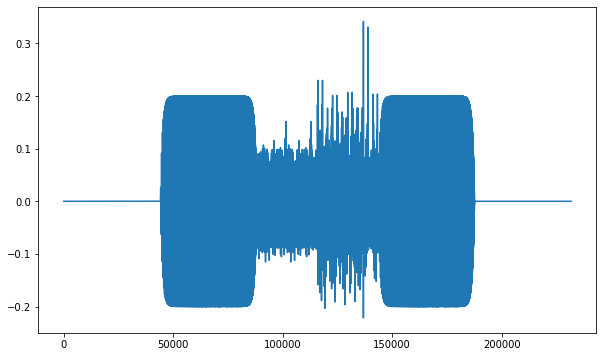

In [27]:
tx_signal, chirp, inverse_chirp, known_frames, carrier_indices, bits_tran = create_tx_waveform('test_files/Short_shakespeare.txt')

plt.figure(figsize=(10,6))
plt.plot(tx_signal)

filename = 'sound_files/transmit.wav'
sf.write(filename, tx_signal, fs)

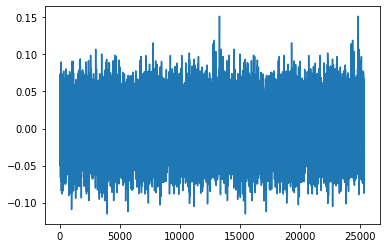

In [28]:
plt.plot(tx_signal[2*fs:2*fs+11*(N+prefix_no)])

In [29]:
### OPTIONAL - TEST OTHER GROUPS FILES
'''
tx_signal, read_fs = sf.read("input_qpsk_22000_noldpc_txt.wav", dtype='float32')
print(read_fs)
plt.plot(tx_signal)
'''

'\ntx_signal, read_fs = sf.read("input_qpsk_22000_noldpc_txt.wav", dtype=\'float32\')\nprint(read_fs)\nplt.plot(tx_signal)\n'

In [31]:

#rx_signal = ideal_channel_response(tx_signal)
rx_signal = real_channel_response_file("sound_files/Rec38.m4a")


In [32]:
rx_convolution, peak_start, peak_end = matched_filter(rx_signal, inverse_chirp)

print("Peak start: ", peak_start)
print("Peak end: ", peak_end)

expected_ch_gap = len(tx_signal) - len(inverse_chirp) - 2*fs
actual_ch_gap = peak_end - peak_start

sampling_ratio = actual_ch_gap / expected_ch_gap
#extra_sample_after = int((1/(sampling_ratio-1)))

print("Actual sampling frequency: ", 44100*sampling_ratio)
#print("Extra sample after every", extra_sample_after , "samples")

Peak start:  98515
Peak end:  197911
Actual sampling frequency:  44100.0


In [33]:
def channel_estimate(signal, start, known_frames, offset=0):
    """Given a signal and the index of the chirp end, calculates the channel frequency
    and impulse response"""
    
    start += N+prefix_no - offset # account for extra filler OFDM frame of length 2304
    length = (N+prefix_no) * 10 # as using 10 ofdm frames
    trimmed_frames = signal[start:start+length]
    split_frames = np.split(trimmed_frames, 10)
    
    split_known_frames = np.split(known_frames, 10)
    
    channel_freq_response = np.zeros(N)
    
    for i in range(10):
        known_frame = split_known_frames[i][prefix_no:]
        rx_frame = split_frames[i][prefix_no:]
        known_dft = np.fft.fft(known_frame, N)
        rx_dft = np.fft.fft(rx_frame, N)
        
        # try using N rather than N//2 then don't append? should give same result
        single_freq_response = np.zeros(N//2, dtype=complex)
        np.divide(rx_dft[:N//2], known_dft[:N//2], out=single_freq_response, where=known_dft[:N//2] != 0) # should catch divide by zero errors
        single_freq_response = np.append(single_freq_response, np.append(0,np.conj(single_freq_response)[:0:-1]))
        
        channel_freq_response = np.add(channel_freq_response, single_freq_response)
    
    channel_freq_response /= 10 # average out
    
    channel_imp_response = np.fft.ifft(channel_freq_response, N)
    channel_imp_response = np.real(channel_imp_response)
    
    return channel_freq_response, channel_imp_response, split_frames


In [53]:
offset = 30
freq_response, imp_response, rx_known_frames = channel_estimate(rx_signal, peak_start, known_frames, offset)

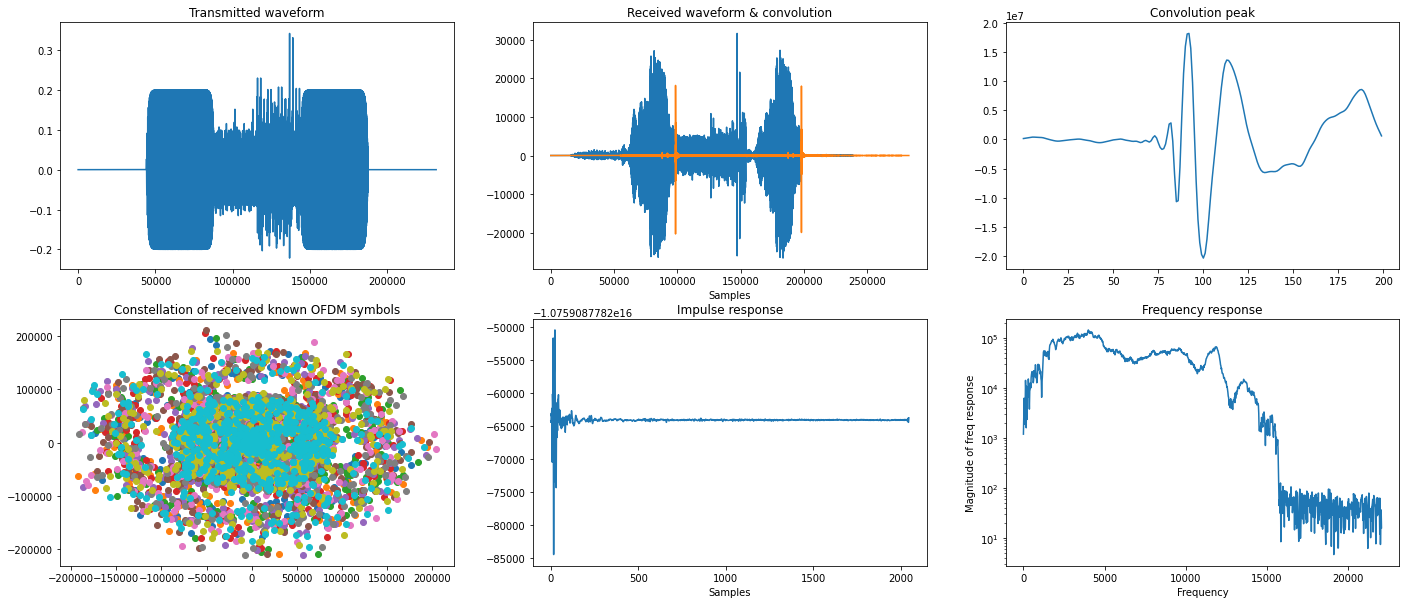

In [54]:
figs, axs = plt.subplots(2, 3, figsize=(24,10))
axs[0][0].plot(tx_signal)
axs[0][0].set_title('Transmitted waveform')
axs[0][1].plot(rx_signal)
axs[0][1].set_title('Received waveform & convolution')
axs[0][1].plot(rx_convolution/1000)
axs[0][1].set_xlabel('Samples')
axs[0][2].set_title('Convolution peak')
axs[0][2].plot(rx_convolution[peak_start-100:peak_start+100])

for i in range(len(rx_known_frames)):
    tst_symbols = np.fft.fft(rx_known_frames[i][prefix_no:], N)[1:N//2]
    axs[1][0].scatter(np.real(tst_symbols), np.imag(tst_symbols), label=i)
axs[1][0].set_title('Constellation of received known OFDM symbols')


axs[1][1].set_title('Impulse response')
axs[1][1].set_xlabel('Samples')
axs[1][1].plot(imp_response)
axs[1][2].set_title('Frequency response')
axs[1][2].set_ylabel('Magnitude of freq response')
axs[1][2].set_xlabel('Frequency')
axs[1][2].semilogy(np.linspace(1, fs//2 -1, N//2-2), np.abs(freq_response[1:N//2-1]))

In [65]:
offset_data = 20

29952
52992
(13, 2304)


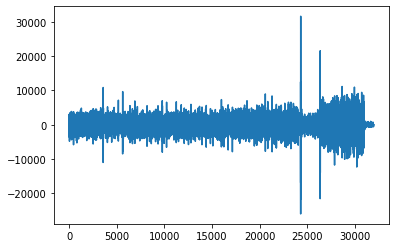

In [66]:
data_begin = peak_start + 11*(N+prefix_no) - offset_data # as 1 random & 10 known ofdm frames after chirp
data_end = peak_end - len(inverse_chirp) - offset_data # use end chirp to determine signal length for now, will need a fix later
# potential for data_being -> data_end to not be the correct length
print(data_end - data_begin)
print(len(tx_signal)-2*fs-2*len(inverse_chirp)-(N+prefix_no))
# TEMP FIX

rx_data_full = rx_signal[data_begin:data_end]
rx_data_frames = np.split(rx_data_full, len(rx_data_full)/(N+prefix_no))
print(np.shape(rx_data_frames))
plt.plot(rx_signal[data_begin-1000:data_end+1000])

In [67]:
preamble_points = np.arange(0, len(rx_data_frames), 11)
just_data = np.delete(rx_data_frames, preamble_points, axis=0)
print(len(just_data))

11


In [68]:
def correct_phase_decode_data(all_frames, carrier_indices, channel_fft, filename, pilot_value=1+1j):
    
    pilot_indices = carrier_indices[0]
    data_indices = np.array(carrier_indices[1])
    
    pilot_symbols = []
    data_symbols = []
    
    preamble_points = np.arange(0, len(rx_data_frames), 11) # remove preamble frame before each set of 10 data blocks
    data_frames = np.delete(all_frames, preamble_points, axis=0)
    
    bits = ""
    for i in range(len(data_frames)):
        
        frame_no_cp = data_frames[i][prefix_no:]
        frame_dft = np.fft.fft(frame_no_cp)

        pilots = frame_dft[pilot_indices]
        data = frame_dft[data_indices]
        
        pilots_demod = pilots / channel_fft[pilot_indices]
        pilots_phase_change = np.angle(pilots_demod / pilot_value) # divide by each known pilot symbol and get phase change
        
        phase_adjustment = np.polyfit(pilot_indices, np.unwrap(pilots_phase_change), 1)[0] # take gradient, intercept should be zero
        
        pilots *=  np.exp(-1j*phase_adjustment*pilot_indices)
        data *=  np.exp(-1j*phase_adjustment*data_indices)

        bits+=decode_symbols_2_bitstring(data, channel_fft[data_indices])
        
        pilot_symbols.append(pilots)
        data_symbols.append(data)
        
    bitstr_to_file(bits, filename)
    
    return data_symbols, pilot_symbols, bits

def correct_phase_decode_data_ldpc(all_frames, carrier_indices, channel_fft, filename, pilot_value=1+1j):
    
    pilot_indices = carrier_indices[0]
    data_indices = np.array(carrier_indices[1])
    
    pilot_symbols = []
    data_symbols = []
    
    preamble_points = np.arange(0, len(rx_data_frames), 11) # remove preamble frame before each set of 10 data blocks
    data_frames = np.delete(all_frames, preamble_points, axis=0)
    
    ys=np.array([])
    cks=np.array([])
    
    bits = ""
    for i in range(len(data_frames)):
        
        frame_no_cp = data_frames[i][prefix_no:]
        frame_dft = np.fft.fft(frame_no_cp)

        pilots = frame_dft[pilot_indices]
        data = frame_dft[data_indices]
        
        pilots_demod = pilots / channel_fft[pilot_indices]
        pilots_phase_change = np.angle(pilots_demod / pilot_value) # divide by each known pilot symbol and get phase change
        
        phase_adjustment = np.polyfit(pilot_indices, np.unwrap(pilots_phase_change), 1)[0] # take gradient, intercept should be zero
        
        pilots *=  np.exp(-1j*phase_adjustment*pilot_indices)
        data *=  np.exp(-1j*phase_adjustment*data_indices)

        #bits+=decode_symbols_2_bitstring(data, channel_fft[data_indices])
        
        ys=np.concatenate((ys,data))
        cks=np.concatenate((cks,channel_fft[data_indices]))
        
        pilot_symbols.append(pilots)
        data_symbols.append(data)
        
    assert len(ys)==len(cks)
    bits, file_type=LDPC_decode_with_niceCKs(ys,N,rate=rate,r=r,z=z,inputLenIndicator_len=inputLenIndicator_len, cks=cks,len_protection=len_protection,repeat_times=repeat_times)

    if filename:
        bitstr_to_file(bits, filename)
    
    return data_symbols, pilot_symbols, bits


In [73]:
def test(offset, offset_data):

    freq_response, imp_response, all_frames = channel_estimate(rx_signal, peak_start, known_frames, offset)

    #offset_data = - offset

    data_begin = peak_start + 11*(N+prefix_no) - offset_data
    data_end = peak_end - len(inverse_chirp) - offset_data 
    rx_data_full = rx_signal[data_begin:data_end]
    rx_data_frames = np.split(rx_data_full, int(len(rx_data_full)/(N+prefix_no)))

    data_symbols, pilot_symbols, bits_rec = correct_phase_decode_data_ldpc(rx_data_frames, carrier_indices, freq_response, 'deco.txt', 1+1j)
    return error_rate(bits_tran, bits_rec)

In [76]:
test(22,22)

inside LDPC_decode_with_niceCKs
type(ys_)= <class 'numpy.ndarray'>
type(cks)= <class 'numpy.ndarray'>
about to ys_=ys_/ cks
ys_=ys_/ cks finished
about to do ys=separate_real_img(ys_)
about to do divide_codebits
about to loop
decoding 0th LDPC block, 7 in total------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
 tif= 2  txt= 1  wav= 0
file_type:  .tif
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------

total_length:  5726602548
decoding 6th LDPC block, 7 in total

ValueError: last block not detected

In [77]:
list = []
for i in range(-20,20,1):
    for j in range(-20,20,1):
        try:
            list.append([i,j,test(i,j)])
        except:
            pass

-----
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------

total_length:  5726602548
decoding 6th LDPC block, 7 in totalinside LDPC_decode_with_niceCKs
type(ys_)= <class 'numpy.ndarray'>
type(cks)= <class 'numpy.ndarray'>
about to ys_=ys_/ cks
ys_=ys_/ cks finished
about to do ys=separate_real_img(ys_)
about to do divide_codebits
about to loop
decoding 0th LDPC block, 7 in total------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
 tif= 2  txt= 1  wav= 1
file_type:  .tif
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected

In [80]:
list = np.array(list)
list[np.argsort(list[:, 2])]

array([[  7.        ,   4.        ,   0.02302632],
       [  1.        ,  15.        ,   0.02747678],
       [ -4.        ,  15.        ,   0.03115325],
       ...,
       [  8.        ,  19.        ,   1.        ],
       [-14.        ,   0.        ,   1.        ],
       [ 13.        ,  -5.        ,   1.        ]])

In [81]:
test(7,4)

inside LDPC_decode_with_niceCKs
type(ys_)= <class 'numpy.ndarray'>
type(cks)= <class 'numpy.ndarray'>
about to ys_=ys_/ cks
ys_=ys_/ cks finished
about to do ys=separate_real_img(ys_)
about to do divide_codebits
about to loop
decoding 0th LDPC block, 7 in total tif= 2  txt= 0  wav= 0
file_type:  .tif

total_length:  10336
decoding 5th LDPC block, 7 in total
about to write file, the filename inputed is:  deco.txt
bitstr written to  deco.txt
<ipython-input-42-4df0ffe901aa>:3: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  a1 = np.fromstring(bits_tran, 'u1') - ord('0')
<ipython-input-42-4df0ffe901aa>:4: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  a2 = np.fromstring(bits_rec, 'u1') - ord('0')


0.023026315789473683

In [83]:
test(7,7)

inside LDPC_decode_with_niceCKs
type(ys_)= <class 'numpy.ndarray'>
type(cks)= <class 'numpy.ndarray'>
about to ys_=ys_/ cks
ys_=ys_/ cks finished
about to do ys=separate_real_img(ys_)
about to do divide_codebits
about to loop
decoding 0th LDPC block, 7 in total tif= 2  txt= 0  wav= 0
file_type:  .tif

total_length:  10336
decoding 5th LDPC block, 7 in total
about to write file, the filename inputed is:  deco.txt
bitstr written to  deco.txt
<ipython-input-42-4df0ffe901aa>:3: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  a1 = np.fromstring(bits_tran, 'u1') - ord('0')
<ipython-input-42-4df0ffe901aa>:4: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  a2 = np.fromstring(bits_rec, 'u1') - ord('0')


0.32140092879256965

In [71]:
data_begin = peak_start + 11*(N+prefix_no) - offset_data # as 1 random & 10 known ofdm frames after chirp
data_end = peak_end - len(inverse_chirp) - offset_data # use end chirp to determine signal length for now, will need a fix later

rx_data_full = rx_signal[data_begin:data_end]
rx_data_frames = np.split(rx_data_full, len(rx_data_full)/(N+prefix_no))
print(np.shape(rx_data_frames))
plt.plot(rx_signal[data_begin-1000:data_end+1000])

data_symbols, pilot_symbols, bits_rec = correct_phase_decode_data_ldpc(rx_data_frames, carrier_indices, freq_response, 'deco.txt', 1+1j)

(13, 2304)
inside LDPC_decode_with_niceCKs
type(ys_)= <class 'numpy.ndarray'>
type(cks)= <class 'numpy.ndarray'>
about to ys_=ys_/ cks
ys_=ys_/ cks finished
about to do ys=separate_real_img(ys_)
about to do divide_codebits
about to loop
decoding 0th LDPC block, 7 in total------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
 tif= 0  txt= 2  wav= 0
file_type:  .txt
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error correcte

ValueError: last block not detected

In [69]:
data_symbols, pilot_symbols, bits_rec = correct_phase_decode_data_ldpc(rx_data_frames, carrier_indices, freq_response, 'deco.txt', 1+1j)

inside LDPC_decode_with_niceCKs
type(ys_)= <class 'numpy.ndarray'>
type(cks)= <class 'numpy.ndarray'>
about to ys_=ys_/ cks
ys_=ys_/ cks finished
about to do ys=separate_real_img(ys_)
about to do divide_codebits
about to loop
decoding 0th LDPC block, 7 in total------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
 tif= 0  txt= 2  wav= 0
file_type:  .txt
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
------error corrected-------
--

ValueError: last block not detected

In [42]:
def error_rate(bits_tran, bits_rec):
    length = min(len(bits_tran),len(bits_tran))
    a1 = np.fromstring(bits_tran, 'u1') - ord('0')
    a2 = np.fromstring(bits_rec, 'u1') - ord('0')
    a2 = a2[0:length]
    return (length - np.sum(a1 == a2)) / length

In [43]:
error_rate(bits_tran, bits_rec)

<ipython-input-42-4df0ffe901aa>:3: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  a1 = np.fromstring(bits_tran, 'u1') - ord('0')
<ipython-input-42-4df0ffe901aa>:4: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  a2 = np.fromstring(bits_rec, 'u1') - ord('0')


0.0